In [1]:
from etc.init import *
import etc.figureslib as lib

import NotebookScripter
from NotebookScripter import run_notebook, receive_parameter
NotebookScripter.set_notebook_option(with_matplotlib_backend=None)
savefig = receive_parameter(savefig=False)
saveext = receive_parameter(saveext='pdf')
try:
    data
except NameError:
    data = receive_parameter(data=None)
    
if data is None:
    data = run_notebook("Figures_load_data.ipynb")
records = data.records

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
[monochrome_palette]: value was greater than 1 and was clipped.



import copy
import os.path
import itertools
from collections import Iterable, OrderedDict, namedtuple, deque
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image
from matplotlib.gridspec import GridSpec
import pymc3 as pymc
import pandas as pd
from pandas import DataFrame
from parameters import ParameterSet

from importlib import reload

import theano_shim as shim

import mackelab as ml
import mackelab.smttk as smttk
import mackelab.iotools
import mackelab.pymc3
import mackelab.parameters
import mackelab.plot
ml.parameters.Transform.namespaces['shim'] = shim

import sinn
import sinn.histories as histories
import sinn.models
from sinn.optimize.gradient_descent import FitCollection
import sinn.analyze as anlz
from sinn.analyze.axisdata import LogLikelihood, Likelihood, Probability
from sinn.analyze.axis import Axis

import fsGIF.core as core
import fsGIF.fsgif_model as fsgif_model
from fsGIF.fsgif_model

---
The initial cell which imports *matplotlib* seems to initialize some settings on exit (like setting `figure.dpi` to `72`). To ensure plot styles are all applied, they should be done in a separate cell.

In [2]:
mplconfig = run_notebook("Figures_matplotlib_config.ipynb")
inject_vars(mplconfig, globals())

In [3]:
import seaborn as sns

In [4]:
outputname = "Fig_cstI.pdf"

In [5]:
result_seeds = np.arange(300,400)
truemicro_seeds = np.arange(1300,1400)
truemeso_seeds = np.arange(2300,2400)
use_expected_activity = False
num_ref_records = 50

In [6]:
records.filter.any.reason(("cstI", "constant")).summary

,# records,reason,outcome,tags,main_file,avg . duration
20200229-013019,20,sgd_test_cstI,,,../code/fsGIF/gradient_descent.py,5h 09m 27s
20200207-113346,100,fig_cstI_true-meso,,,../code/fsGIF/generate_activity.py,2h 03m 50s
20200207-112507,100,fig_cstI_true_meso_25-fits,,,../code/fsGIF/generate_activity.py,2h 04m 14s
20200204-114338,100,fig_cstI_true-micro,,,../code/fsGIF/generate_spikes.py,4h 49m 11s
20200202-140422,100,fig_cstI_inferred_meso_25-fits,,,../code/fsGIF/generate_activity.py,0h 54m 30s
20200202-140250,1,constant_input__0.5,,,../code/fsGIF/generate_input.py,0h 00m 05s
20200202-135810,1,constant_input__0.5,,,../code/fsGIF/generate_input.py,0h 00m 06s


In [120]:
def get_psd(data, dt=0.001, transient=10., subsample=1):
    """
    data: RecordList | RecordView | History
    fmax, fmax: float
    dt: float. Data will be subsampled to this dt before computing FFT
    transient: float. Length of initial transient to discard (in seconds)
    subsample: int
        If >1, subsample by averaging neigbouring bins.
    """
    if isinstance(data, (lib.RecordSet, lib.RecordList)):
        data.list  # Allow calling length
        Ntrials = len(data)
        traceit = lib.trace_iterator(data, dt=dt)
        trace = next(traceit)
        psd, farr, rate = get_psd(trace, dt=dt,
                                  transient=transient, subsample=subsample
                                 ).values()
        psd /= Ntrials
        rate /= Ntrials
        for trace in traceit:
            _psd, _farr, _rate = get_psd(trace, dt=dt,
                                         transient=transient, subsample=subsample
                                        ).values()
            assert np.all(np.isclose(farr, _farr))
            psd += _psd/Ntrials
            rate += _rate/Ntrials
    elif isinstance(data, (lib.Record, lib.RecordView)):
        psd, farr, rate = get_psd(load_trace(data, dt=dt), fmax, fmin).values()
    else:
        assert isinstance(data, histories.History)
        Δi = data.index_interval(transient, allow_rounding=True)
        trace = data.trace[Δi:]
        rate = trace.mean(axis=0)
        xF = np.fft.rfft(trace, axis=0)
        farr = np.fft.rfftfreq(len(trace))[1:] / data.dt
        psd = abs(xF[1:]**2) * data.dt/len(trace)
        if subsample > 1:
            farr = anlz.subsample(farr, amount=subsample)
            psd  = anlz.subsample(psd,  amount=subsample)
    return AttrDict(psd=psd, freqs=farr, rate=rate)

In [8]:
def load(rec):
    if not isinstance(rec, (ml.smttk.Record, ml.smttk.RecordView)):
        rec = records.get(rec)
    return lib.load_trace(rec, dt=0.001)

In [9]:
labels = lib.AxAttrs(
    true_micro = "True – micro",
    true_meso  = "Theory – meso",
    map_meso   = "Inferred – meso"
)

In [10]:
recsets = lib.AxAttrs(
    true_micro = lib.RecordSet('20200204-114338'),
    true_meso  = lib.RecordSet('20200207-113346'),
    map_meso   = lib.RecordSet('20200202-140422')
)

In [11]:
df = pd.DataFrame({'# runs': {model: len(recset.list)
                   for model, recset in recsets.items()}})
df

,# runs
map_meso,100
true_meso,66
true_micro,70


In [116]:
sampletraces = lib.AxAttrs({k: load(recs.earliest)
                         for k,recs in recsets.items()})

In [13]:
Ihist = ml.iotools.load(records.get('20200202-140250').outputpath[0])

In [68]:
tracecolours = lib.AxAttrs(
    true_micro = colours[2],
    true_meso  = colours[1],
    map_meso   = colours[0]
)
αs = lib.AxAttrs(
    true_micro = 1.,
    true_meso  = 0.85,
    map_meso   = 0.75
)
zerolinegray = '#888888'

In [15]:
try:
    tqdm._instances.clear()
except AttributeError:
    pass

In [121]:
psds = AttrDict({k: get_psd(traces, transient=10., subsample=5)
                 for k,traces in recsets.items()})

100%|██████████| 100/100 [00:00<00:00, 110.02it/s]


In [17]:
def trimy(ax):
    """Copied from seaborn.despine."""
    yticks = ax.get_yticks()
    if yticks.size:
        firsttick = np.compress(yticks >= min(ax.get_ylim()),
                                yticks)[0]
        lasttick = np.compress(yticks <= max(ax.get_ylim()),
                               yticks)[-1]
        ax.spines['left'].set_bounds(firsttick, lasttick)
        ax.spines['right'].set_bounds(firsttick, lasttick)
        newticks = yticks.compress(yticks <= lasttick)
        newticks = newticks.compress(newticks >= firsttick)
        ax.set_yticks(newticks)

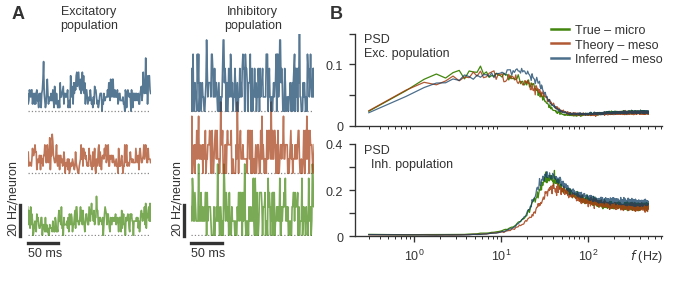

In [127]:
fig = plt.figure(figsize=(textwidth, 0.67*figheight))

gs = GridSpec(2,3)

axes = AttrDict()
axes.Etraces = plt.subplot(gs[:,0])
axes.Itraces = plt.subplot(gs[:,1])
axes.Epsd    = plt.subplot(gs[0,2])
axes.Ipsd    = plt.subplot(gs[1,2])

ax = axes.Etraces
offset = 40
for i, model in enumerate(['true_micro', 'true_meso', 'map_meso']):
    trace = sampletraces[model]
    c = tracecolours[model]
    label = labels[model]
    ax.axhline(i*offset, color=zerolinegray, zorder=-3, linestyle='dotted')
    ax.plot(trace.time, trace.trace[:,0] + i*offset,
            color=c, linewidth=1, alpha=0.7, label=label);
ax.set_xlim(10, 10.2)
ax.set_ylim(-0.75, 50+2*offset)
ax.set_title("Excitatory\npopulation", pad=3,
             fontweight='normal', fontsize=mpl.rcParams['axes.labelsize'])
ml.plot.draw_xscale(0.05, "50 ms", offset=0, yshift=5, ax=ax)
ml.plot.draw_yscale(20, "20 Hz$/$neuron", offset=0, xshift=10, ax=ax)

ax = axes.Itraces
offset = 40
for i, model in enumerate(['true_micro', 'true_meso', 'map_meso']):
    trace = sampletraces[model]
    c = tracecolours[model]
    label = labels[model]
    ax.axhline(i*offset, color=zerolinegray, zorder=-3, linestyle='dotted')
    ax.plot(trace.time, trace.trace[:,1] + i*offset,
            color=c, linewidth=1, alpha=0.7, label=label);
ax.set_xlim(10, 10.2)
ax.set_ylim(-0.75, 50+2*offset)
ax.set_title("Inhibitory\npopulation", pad=3,
             fontweight='normal', fontsize=mpl.rcParams['axes.labelsize'])
ml.plot.draw_xscale(0.05, "50 ms", offset=0, yshift=5, ax=ax)
ml.plot.draw_yscale(20, "20 Hz$/$neuron", offset=0, xshift=10, ax=ax)
#ax.spines['left'].set_visible(False)
#ax.set_yticks([]);

ax = axes.Epsd
for model in ['true_micro', 'true_meso', 'map_meso']:
    c = tracecolours[model]
    psd = psds[model]
    α = αs[model]
    label = labels[model]
    ax.plot(psd.freqs, psd.psd[:,0], color=c, alpha=α, label=label)
ax.set_xscale('log')
ax.set_xticks([])
ax.set_ylim(0, 0.15)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels(["0", "", "0.1", ""])
ax.set_ylabel("PSD\nExc. population")
ax.yaxis.label.set_rotation('horizontal')
ax.yaxis.label.set_ha('left')
ax.yaxis.label.set_va('top')
ax.yaxis.set_label_coords(0.03,1)
#sns.despine(ax=ax, offset=2)
#trimy(ax)
    
ax = axes.Ipsd
for model in ['true_micro', 'true_meso', 'map_meso']:
    c = tracecolours[model]
    psd = psds[model]
    α = αs[model]
    ax.plot(psd.freqs, psd.psd[:,1], color=c, alpha=α)
ax.set_xscale('log')
ax.set_ylim(0, 0.4)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels(["0", "", "0.2", "", "0.4"]);
ax.set_xlabel("$f$ (Hz)")
ax.xaxis.set_label_coords(1,-0.12)
ax.xaxis.label.set_ha('right')
ax.set_ylabel("PSD\n  Inh. population")
ax.yaxis.label.set_rotation('horizontal')
ax.yaxis.label.set_ha('left')
ax.yaxis.label.set_va('top')
ax.yaxis.set_label_coords(0.03,1)
#sns.despine(ax=ax, offset=2)
#trimy(ax)

gs.set_width_ratios([1,1,2.5])
gs.update(left=0.04, right=0.96, top=0.88, bottom=0.17, wspace=0.22)

# Legend
#axes.Itraces.legend(ncol=3, loc='lower left', bbox_to_anchor=(1,1),
#                    borderpad=1, handletextpad=0.5, columnspacing=1.45);
#ml.plot.set_legend_linewidth(2.5, ax=axes.Itraces)
axes.Epsd.legend(ncol=1, loc='upper right', bbox_to_anchor=(1,1.1))
ml.plot.set_legend_linewidth(1.5, ax=axes.Epsd)

# Panel labels
ml.plot.subreflabel(axes.Etraces, "a", x=-0.13, y=1.055)
ml.plot.subreflabel(axes.Epsd, "b", x=-0.08, y=1.12)

assert(outputname=='Fig_cstI.pdf')
if savefig:
    plt.savefig("figures/" + os.path.splitext(outputname)[0] + '.' + saveext.strip('.'))

In [128]:
models = ['true_micro', 'true_meso', 'map_meso']
firing_rates = pd.DataFrame([psds[model].rate for model in models],
                             index=models, columns=['E', 'I'])
firing_rates

,E,I
true_micro,9.490209,14.340490
true_meso,9.282226,13.502666
map_meso,9.815982,15.701249
